In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

from epsampling.utils import load_csv
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
from epsampling.utils import drop_sers_with_nans
from epsampling.utils import date_str_to_int

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

from IPython.display import Audio

def meow():
    display(Audio(filename='../cat_meow2.wav', autoplay=True))

In [2]:
meow()

In [3]:
from epsampling.modeling import get_full_modeling_dfs

df, df_acs = get_full_modeling_dfs(timestamp='20241009-144131')
df = df[df.True_inc_deaths > 0]

In [4]:
df['Target'] = df.apply(lambda x: (x.True_inc_deaths+1) / x.Pop * 100000, axis=1)
df['Naive'] = df.apply(lambda x: (x.Naive_inc_deaths+1) / x.Pop * 100000, axis=1)
df['State'] = df.apply(lambda x: (x.Proj_inc_deaths+1) / x.State_pop * 100000, axis=1)
df['Cumtm1'] = df.apply(lambda x: (x.Cum_deaths_tm1+1) / x.Pop * 100000, axis=1)
# df['Target'].describe()

In [5]:
# # # # # # # # # #
how_many = 8
# # # # # # # # # #

In [6]:
from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model

chunks = get_chunks(list(df.Date.unique()), 4)
idc = [12]

for idx in idc:
    
    df_train, df_test = get_date_chunked_splits(df, chunks, idx)


    feats = list(df_acs.columns) + ['State','Cumtm1','Naive',
                                   'State_pop','Ratio','Pop']
    
    df_train, df_test = get_date_chunked_splits(df, chunks, idx)
    
    X_train = df_train[feats]
    X_test = df_test[feats]

    y_train = df_train['Target']
    y_test = df_test['Target']
    y_naive = df_test['Naive']
    
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression().fit(X_train, y_train)
    
    y_pred = reg.predict(X_test)

In [7]:
coef = abs(reg.coef_)
# print(coef, abs(coef))
# print(coef)

# print(sorted(coef, reverse=True))
ind = np.argpartition(coef, -how_many)[-how_many:]
top = coef[ind]

# print(ind,top)
df_coefs = X_train.iloc[:, ind]
which_feats = df_coefs.columns

print(which_feats)
# xticks = [acs_dict[x] for x in res_df['feat_name'].values]
# print(xticks)

acs_dict = {'POP_NHPINH':'Native Hawaiian and Pac Islander (NonHisp)',
            'POP_OTH2PLNH': 'Other (NonHisp)',
            'POP_ASIANNH': 'Asian (NonHisp)',
            'POP_AIANNH': 'Am Indian and AK native (NonHisp)',
            'POP_HISP_x12': 'Hispanic',
            'POP_NH': 'NonHisp',
            'POP_BLACKNH': 'Black (NonHisp)',
            'POP_WHITENH': 'White (NonHisp)',            
           }

which_featss = [acs_dict[x] for x in which_feats]

res_df = pd.DataFrame([top, which_featss], index=['coef','feat_name'])
res_df = res_df.T.sort_values(by='coef',inplace=False,ascending=False)
res_df = res_df[:how_many]

Index(['POP_NHPINH', 'POP_HISP_x12', 'POP_WHITENH', 'POP_ASIANNH',
       'POP_OTH2PLNH', 'POP_AIANNH', 'POP_BLACKNH', 'POP_NH'],
      dtype='object')


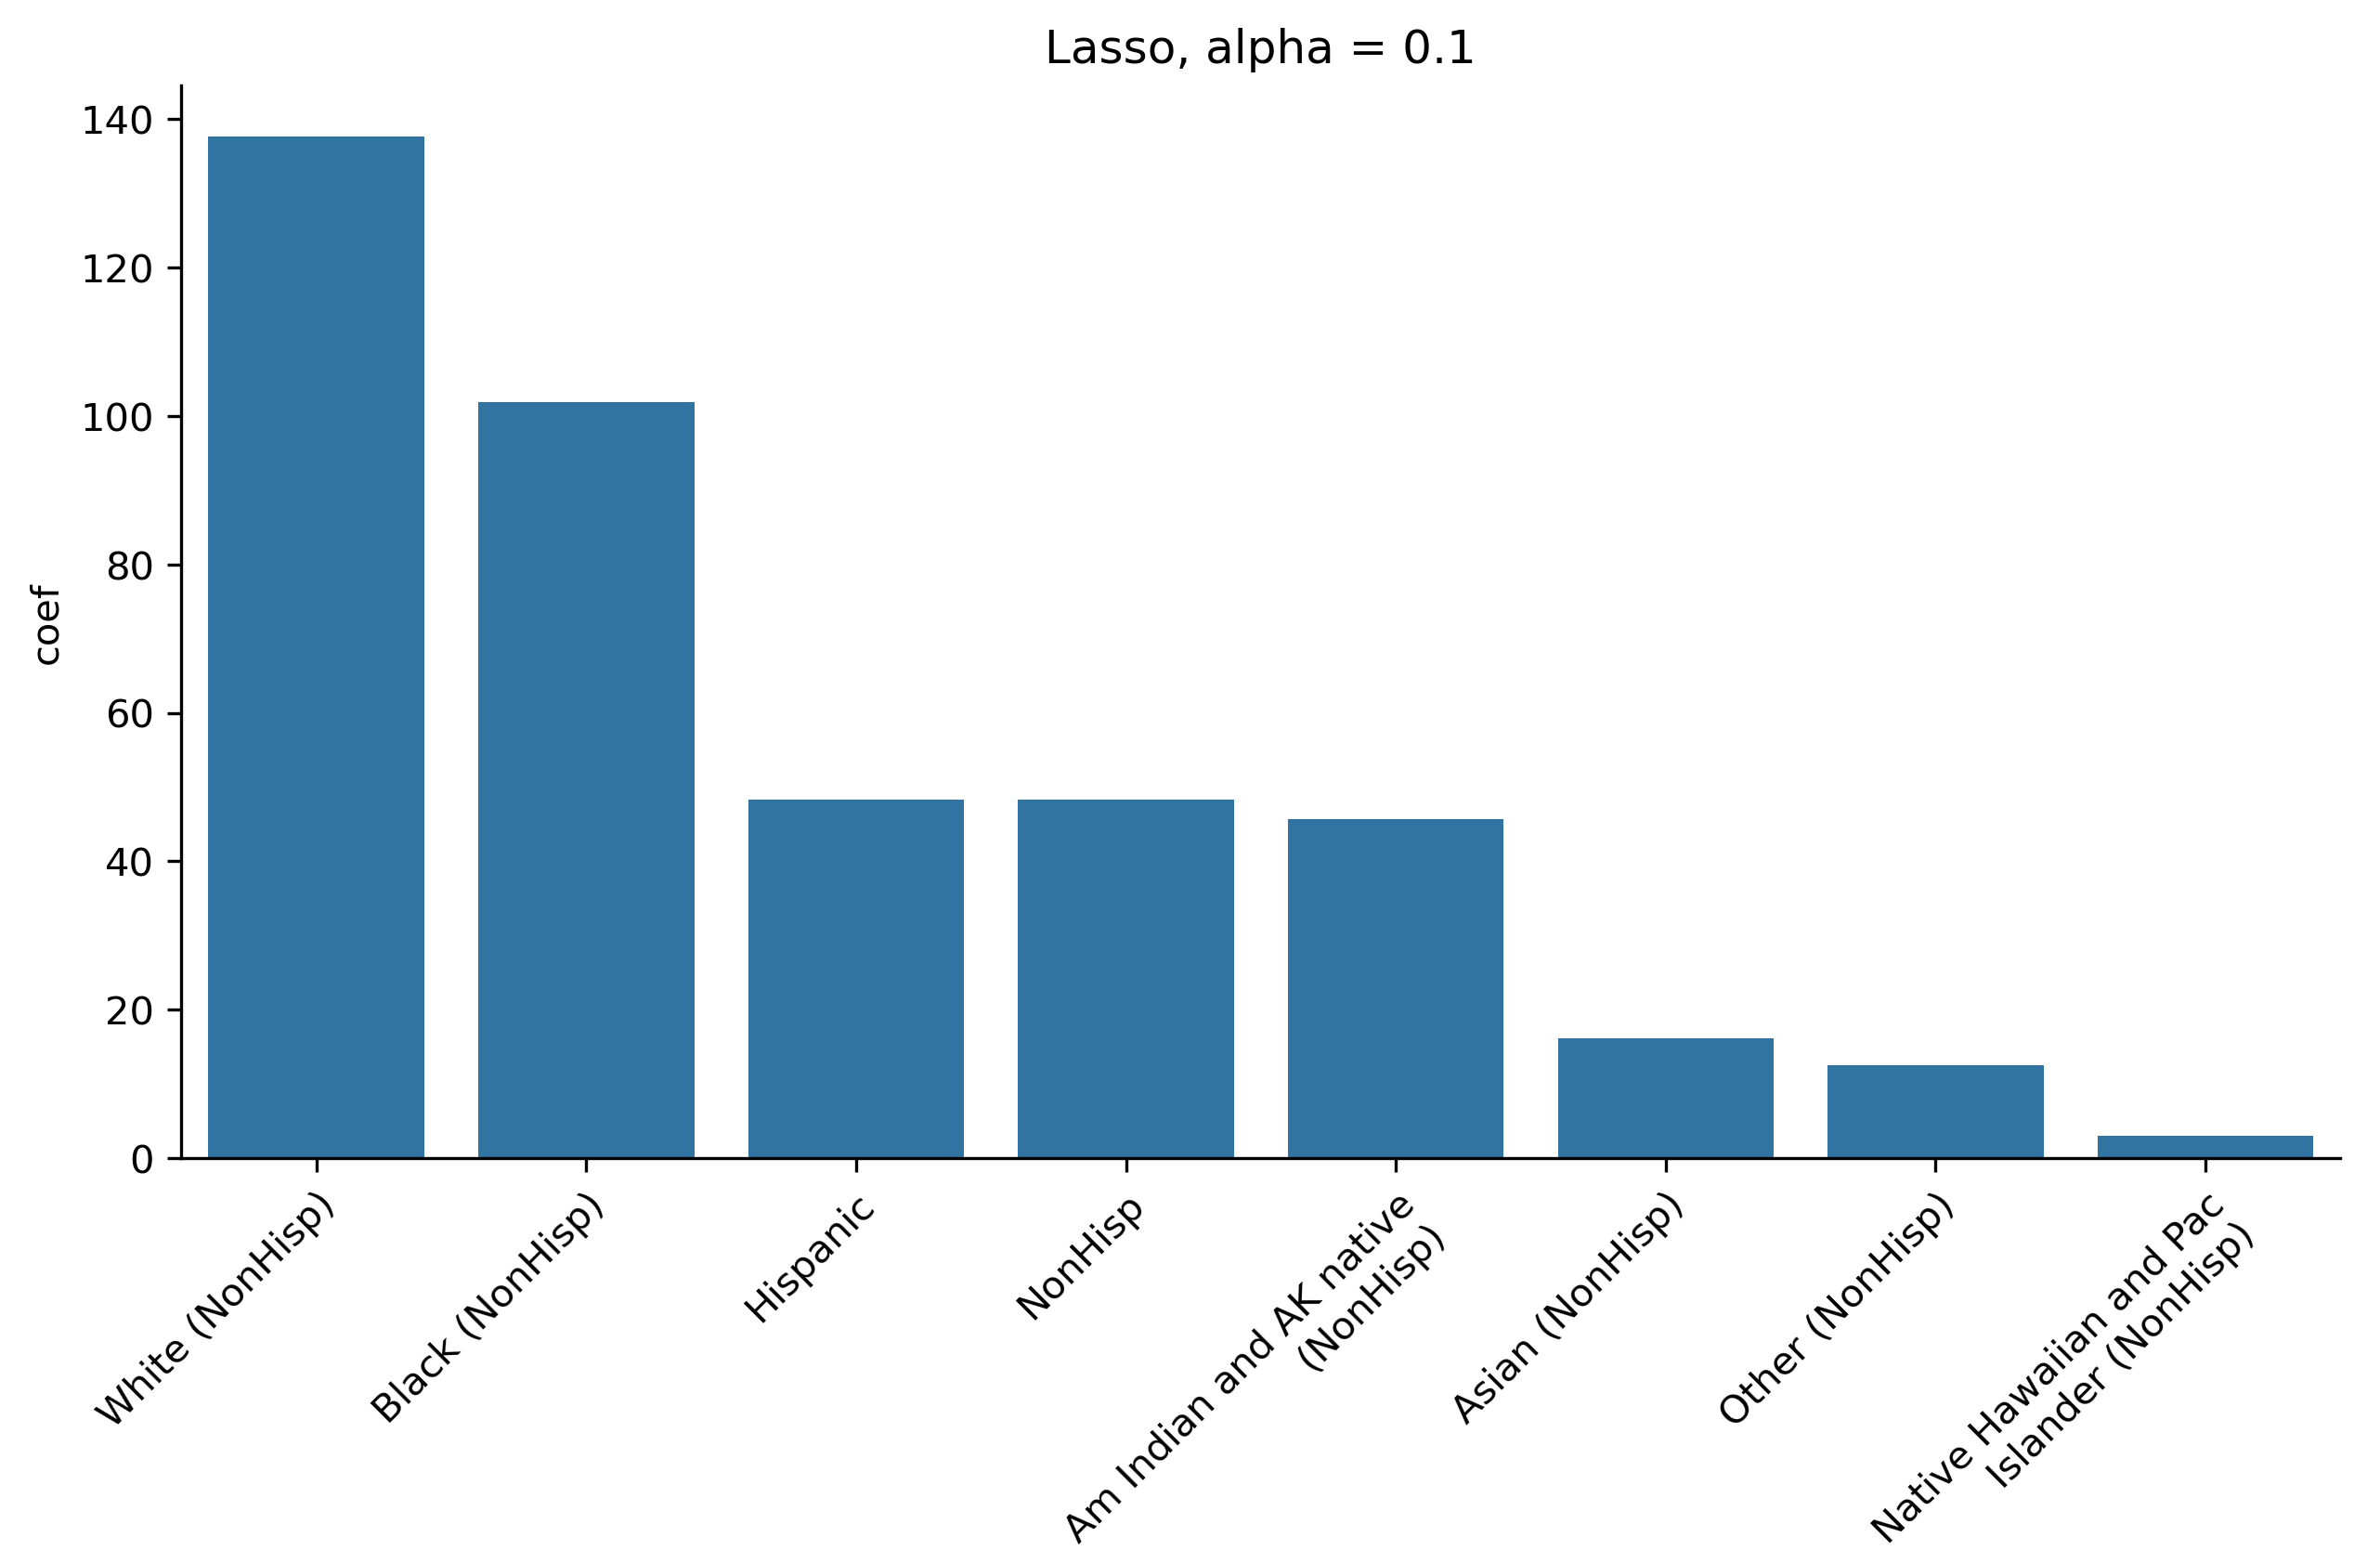

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


# xticks = [acs_dict[x] for x in res_df['feat_name'].values]
# print(xticks)

DPI = 300

plt.figure(figsize=(10,5))
sns.barplot(res_df, y="coef", x="feat_name", legend=False)
plt.title('Lasso, alpha = 0.1')
# plt.xticks(xticks, rotation=45)
plt.xticks(rotation=45,ha='right',wrap='True')

sns.despine()
plt.gcf().set_dpi(DPI)
plt.show()

In [9]:
y_pred = reg.predict(X_test)
y_naive = df_test['Naive']

model_names = ['Deaths_pred', 'Deaths_naive']
model_preds = [y_pred, y_naive]

metrics_dict = get_performance(model_names, model_preds, y_test, y_naive)

for k,v in metrics_dict.items():
    print(f'\n\n* {k} *\n')
    for k2,v2 in v.items():
        if k2=='r2':
            k3 = 'r-squared'
        else:
            k3 = k2
        print(f' • {k3}: \t{round(v2,5)}')



* Deaths_pred *

 • MAE: 	4.47285
 • MedAE: 	2.29073
 • MSE: 	199.83051
 • RMSE: 	14.13614
 • r-squared: 	0.60467
 • relMAE: 	4.81928
 • relMedAE: 	0.79436


* Deaths_naive *

 • MAE: 	6.32735
 • MedAE: 	2.2001
 • MSE: 	319.68217
 • RMSE: 	17.87966
 • r-squared: 	0.36757
 • relMAE: 	1.0
 • relMedAE: 	1.0


In [ ]:
meow()